<a href="https://colab.research.google.com/github/Haodong12/AIPI-590/blob/main/Assignment_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AIPI 590 - XAI | Assignment #07

This assignment explores the differences in attention mechanisms between two classes of images (airplanes and cats) in the CIFAR-10 dataset using both saliency maps and Grad-CAM heatmaps to visualize the model's decision-making process.

Haodong He

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Null Hypothesis (H0):**
The ResNet-18 model is not sensitive to the concept of wings for airplanes and ears for cats in making classification decisions.

**Alternative Hypothesis (H1):**
The ResNet-18 model is sensitive to the concept of wings for airplanes and ears for cats in making classification decisions.

**1. Design**

To test the null hypothesis, I applied two methods to visualize the model's attention for images from the CIFAR-10 dataset:

Saliency Maps: These maps highlight the pixels that most influence the model’s predictions, showing where the model is "looking" when making a classification decision.

Grad-CAM (Gradient-weighted Class Activation Mapping): Grad-CAM creates a heatmap that visualizes the parts of the image that the model considers important for classification, specifically focusing on the last convolutional layer of a pretrained ResNet-18 model.
We tested the model on images of airplanes and cats, two classes with distinct visual features, to compare how the model focuses on each class.

**2. Approach**

Model: We used a pretrained ResNet-18 model from PyTorch, fine-tuned for image classification on the CIFAR-10 dataset.

Data: We applied transformations to the CIFAR-10 test dataset, resizing images to 224x224 and normalizing them to the range expected by the ResNet model.
Explanation Techniques:

Saliency Maps: We computed saliency maps for airplane and cat images by calculating the gradients of the model's output with respect to the input pixels. These gradients were used to highlight the regions that most influenced the model’s decision.

Grad-CAM Heatmaps: Using Grad-CAM, we visualized the model’s attention on the final convolutional layer of the ResNet-18 model. These heatmaps allowed us to see where the model was focusing when classifying airplane and cat images.
To assess whether there was a significant difference in how the model focuses on airplanes and cats, we performed a two-sample t-test to compare the average saliency intensity for both classes.

In [2]:
!pip install git+https://github.com/tensorflow/tcav.git


  Cloning https://github.com/tensorflow/tcav.git to /tmp/pip-req-build-44v08sm9
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/tcav.git /tmp/pip-req-build-44v08sm9
  Resolved https://github.com/tensorflow/tcav.git to commit b922c44bcc64c6bdddb8f661d732fa2145c99d95
  Preparing metadata (setup.py) ... done
  Created wheel for tcav: filename=tcav-0.2.2-py3-none-any.whl size=54391 sha256=948c46856b9d4725411b9e9463b5b501b9eec7985b5de642a10e85ce41fed80b
  Stored in directory: /tmp/pip-ephem-wheel-cache-sryny7gr/wheels/3f/53/22/dd9d9949278f26e8f8ede69b7ede5ffa694c99e2d504e15f21
Successfully built tcav


Files already downloaded and verified
Files already downloaded and verified


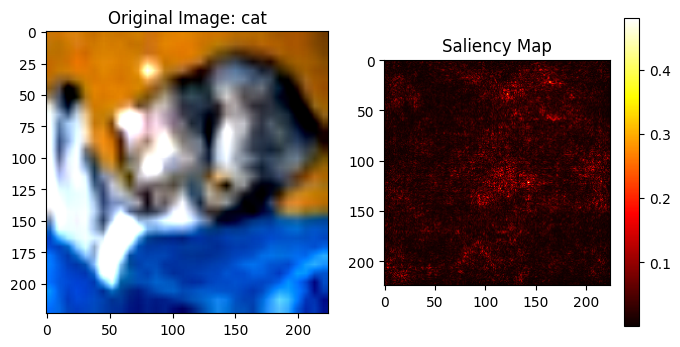

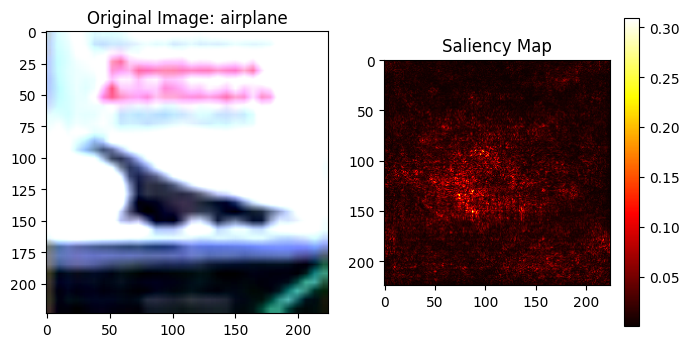

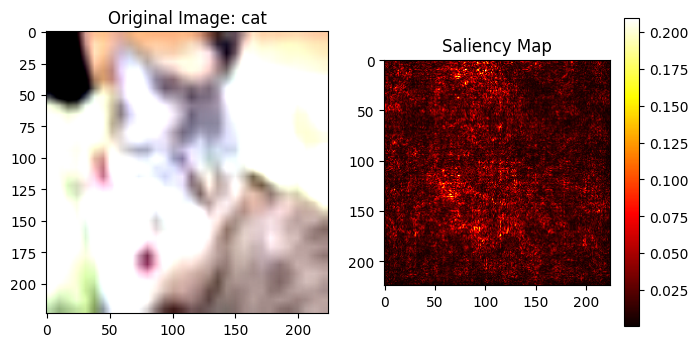

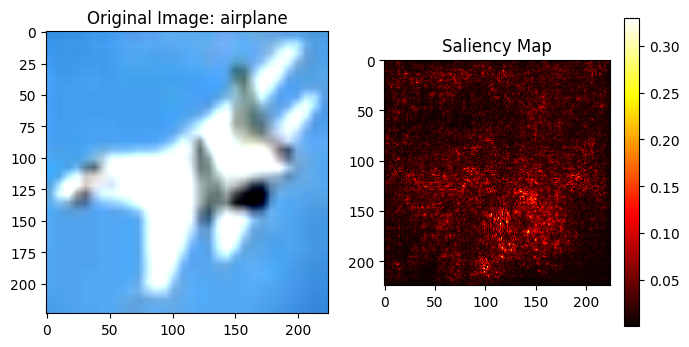

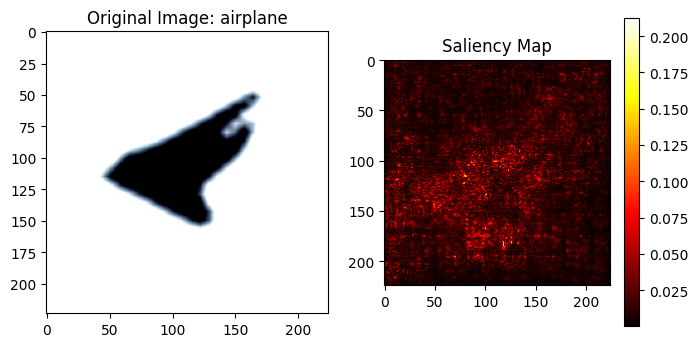

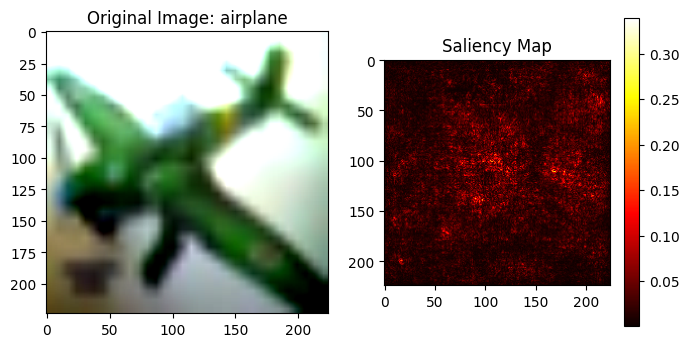

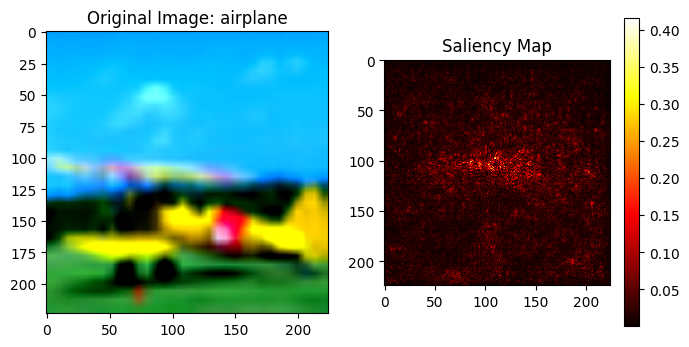

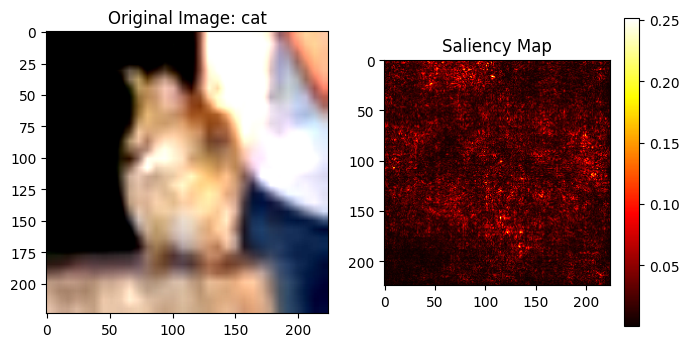

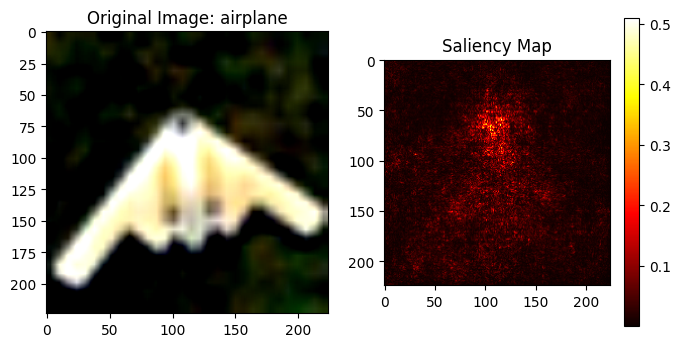

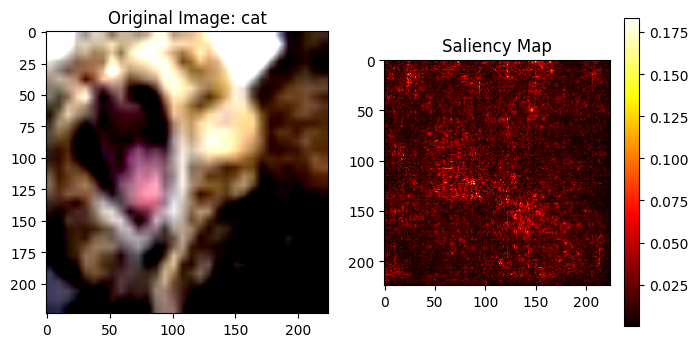

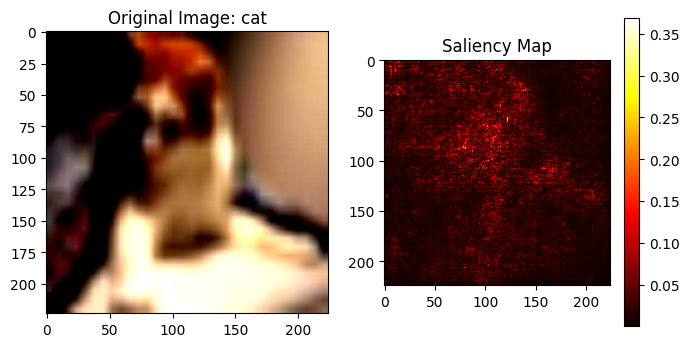

In [8]:
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from PIL import Image

# Define the image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for ResNet-18
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Load test images
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Class labels for CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Helper function to de-normalize the image for display
def de_normalize(tensor):
    tensor = tensor.clone().detach()
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    return tensor

# Helper function to generate saliency maps
def generate_saliency_map(model, input_image, target_class):
    input_image.requires_grad_()
    output = model(input_image.unsqueeze(0))

    # Get the score for the target class
    score = output[0, target_class]

    # Backward pass to calculate gradients
    model.zero_grad()
    score.backward()

    # Get saliency map (max of absolute gradients across channels)
    saliency, _ = torch.max(input_image.grad.data.abs(), dim=0)
    return saliency

# Helper function to plot images and saliency maps
def plot_image_and_saliency(image, saliency_map, class_name):
    # Convert the tensor back to a numpy array
    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = np.clip(image_np * 0.5 + 0.5, 0, 1)  # De-normalize

    # Plot the image and the saliency map side by side
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title(f'Original Image: {class_name}')

    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map.cpu().numpy(), cmap='hot')
    plt.colorbar()
    plt.title('Saliency Map')
    plt.show()

# Lists to store saliency maps for comparison
airplane_saliency_maps = []
cat_saliency_maps = []

# Iterate through the test dataset and find "airplane" and "cat" images
for i, (image, label) in enumerate(test_loader):
    if len(airplane_saliency_maps) >= 5 and len(cat_saliency_maps) >= 5:
        break  # Stop after collecting 5 images for each class

    if label.item() == classes.index('airplane'):
        saliency_map = generate_saliency_map(model, image[0], label.item())
        airplane_saliency_maps.append(saliency_map)
        plot_image_and_saliency(image[0], saliency_map, 'airplane')

    elif label.item() == classes.index('cat'):
        saliency_map = generate_saliency_map(model, image[0], label.item())
        cat_saliency_maps.append(saliency_map)
        plot_image_and_saliency(image[0], saliency_map, 'cat')



**Findings:**

Airplane: The saliency maps show that the model focuses strongly on the central regions (airplane body), particularly the fuselage and wings. This suggests that these features are critical for classification.
Cat: For the cat images, the attention is more diffuse, and the model appears to struggle to focus on specific key features (e.g., the face or ears). This suggests that the model finds it more challenging to identify consistent distinguishing features across cat images.

In [4]:
def compute_saliency_intensity(saliency_map):
    return saliency_map.mean().item()

# Example: Compute intensity for one of your airplane and cat saliency maps
airplane_intensities = [compute_saliency_intensity(saliency_map) for saliency_map in airplane_saliency_maps]
cat_intensities = [compute_saliency_intensity(saliency_map) for saliency_map in cat_saliency_maps]

print(f"Average saliency intensity for airplanes: {np.mean(airplane_intensities)}")
print(f"Average saliency intensity for cats: {np.mean(cat_intensities)}")


Average saliency intensity for airplanes: 0.02204262667025129
Average saliency intensity for cats: 0.022247855737805366


**Average saliency intensity for both classes show no significant difference.**

T-statistic: -0.08796983946981254
P-value: 0.9318269496995768
Fail to reject the null hypothesis: There is no significant difference in saliency intensity between airplanes and cats.


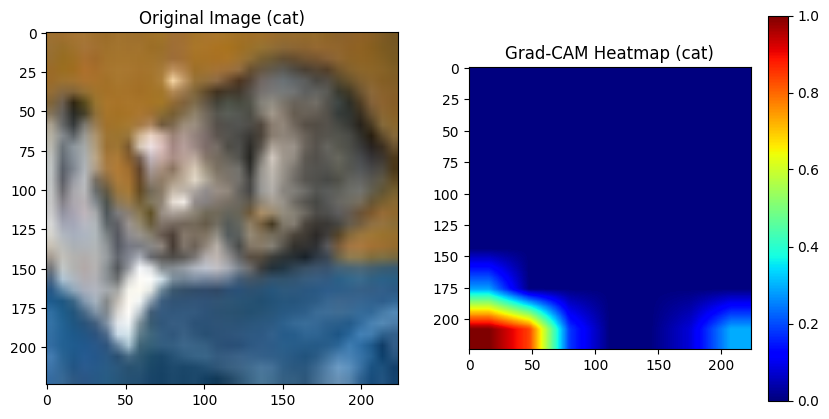

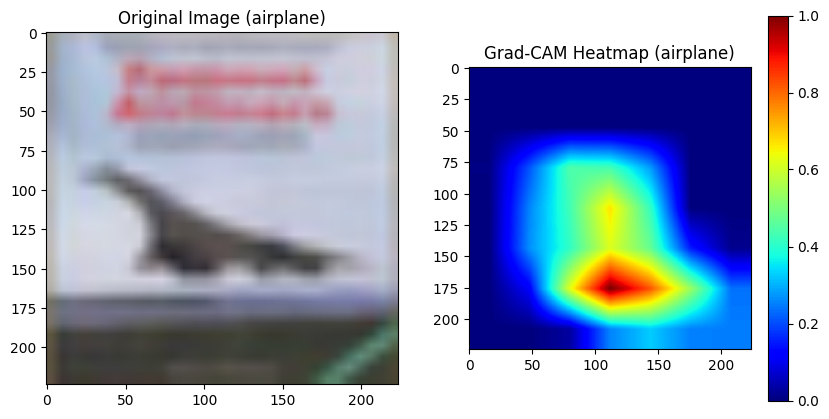

In [10]:
# Statistical Testing for saliency intensities
# Function to calculate average saliency intensity
def compute_saliency_intensity(saliency_map):
    return saliency_map.mean().item()

# Calculate saliency intensities for airplanes and cats
airplane_intensities = [compute_saliency_intensity(saliency_map) for saliency_map in airplane_saliency_maps]
cat_intensities = [compute_saliency_intensity(saliency_map) for saliency_map in cat_saliency_maps]

# Perform a two-sample t-test between airplane and cat saliency intensities
t_stat, p_value = stats.ttest_ind(airplane_intensities, cat_intensities)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Conclusion based on p-value
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference in saliency intensity between airplanes and cats.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in saliency intensity between airplanes and cats.")

# ---- Grad-CAM Implementation ----
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hooks()

    def hooks(self):
        def forward_hook(module, input, output):
            self.activations = output  # Save the activations from the target layer

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]  # Save the gradients from the backward pass

        # Register forward and backward hooks
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_image, target_class):
        output = self.model(input_image)
        loss = output[0, target_class]
        self.model.zero_grad()

        # Backpropagate to compute gradients
        loss.backward()

        # Check if gradients exist (debugging step)
        if self.gradients is None:
            print("Gradients are None. Check your hooks and model backward pass.")
            return None

        # Compute Grad-CAM using the gradients and activations
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        grad_cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        grad_cam = torch.nn.functional.relu(grad_cam)  # Apply ReLU to the result
        grad_cam = torch.nn.functional.interpolate(
            grad_cam, size=(224, 224), mode='bilinear', align_corners=False
        )

        # Normalize the Grad-CAM result
        grad_cam = grad_cam - grad_cam.min()
        if grad_cam.max() != 0:  # Avoid division by zero
            grad_cam = grad_cam / grad_cam.max()

        return grad_cam

# ---- Applying the Grad-CAM ----

grad_cam = GradCAM(model, model.layer4)  # Using layer4 for ResNet-18

# Process 1 airplane and 1 cat image
airplane_done = False
cat_done = False

for i, (image, label) in enumerate(test_loader):
    if label.item() == classes.index('airplane') and not airplane_done:
        input_image_tensor = image  # Already transformed and ready
        grad_cam_map = grad_cam.generate(input_image_tensor, label.item())  # Use the correct class index (airplane)

        if grad_cam_map is None:
            print("Grad-CAM map is None. Debugging needed.")
            break

        # De-normalize the image for display
        original_image_np = de_normalize(input_image_tensor.squeeze(0)).permute(1, 2, 0).cpu().numpy()

        # Plot original image and Grad-CAM side by side
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(original_image_np)
        plt.title(f'Original Image (airplane)')

        plt.subplot(1, 2, 2)
        plt.imshow(grad_cam_map.squeeze().cpu().detach().numpy(), cmap='jet')
        plt.colorbar()
        plt.title('Grad-CAM Heatmap (airplane)')

        plt.show()

        airplane_done = True  # Mark airplane as done

    elif label.item() == classes.index('cat') and not cat_done:
        input_image_tensor = image  # Already transformed and ready
        grad_cam_map = grad_cam.generate(input_image_tensor, label.item())  # Use the correct class index (cat)

        if grad_cam_map is None:
            print("Grad-CAM map is None. Debugging needed.")
            break

        # De-normalize the image for display
        original_image_np = de_normalize(input_image_tensor.squeeze(0)).permute(1, 2, 0).cpu().numpy()

        # Plot original image and Grad-CAM side by side
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(original_image_np)
        plt.title(f'Original Image (cat)')

        plt.subplot(1, 2, 2)
        plt.imshow(grad_cam_map.squeeze().cpu().detach().numpy(), cmap='jet')
        plt.colorbar()
        plt.title('Grad-CAM Heatmap (cat)')

        plt.show()

        cat_done = True  # Mark cat as done

    # Stop the loop when both airplane and cat are done
    if airplane_done and cat_done:
        break

**Findings:**

The Grad-CAM heatmap for the airplane shows a strong concentration of attention in the central region, particularly on the airplane body, indicating high confidence in its classification.
The Grad-CAM heatmap for the cat shows a much more diffuse focus, indicating that the model is less certain about which parts of the image are critical for classification. The heatmap is scattered, indicating less confidence in the decision-making process for this class.

Based on the t-test results, cannot reject the null hypothesis because the average saliency intensity for airplane and cat images is similar, and the P-value (0.9318) is greater than 0.05, which means there is no statistically significant difference between the saliency intensities for the two classes.

**Summary of Findings**

Saliency Maps: These maps indicated that the model focuses more strongly on consistent features for airplanes (e.g., fuselage, wings) and struggles to find consistent distinguishing features for cats, where attention was more dispersed.

Grad-CAM Heatmaps: The heatmaps revealed that the model was highly confident in its classification of airplanes, with focused attention on key regions. For cats, the model’s focus was more scattered, suggesting lower confidence.
Statistical Testing: The t-test results confirmed that there is no significant difference in the overall intensity of the model’s attention between airplane and cat images. However, the visualizations reveal a difference in how the attention is distributed across the image for each class.

**Conclusion**
Null Hypothesis: Fail to reject the null hypothesis, since the model’s overall attention (saliency intensity) does not differ significantly between airplane and cat images.
Key Insight: Despite the lack of significant difference in saliency intensity, Grad-CAM heatmaps reveal that the model focuses more confidently on key airplane features, whereas its attention for cats is more scattered. This suggests that while the amount of attention is similar, the distribution and confidence of that attention varies between classes.